In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1)

batch_size = 32
class_map = {
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}
show_summary = True
show_dataset_analyze = True

In [5]:
# Load Network and Print Summary
from DeepLib.model import CifarNet
from DeepLib.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()

In [6]:
from DeepLib.dataset import get_loader
from DeepLib.transform import get_a_train_transform, get_a_test_transform

train_loader, test_loader = get_loader('CIFAR10',get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

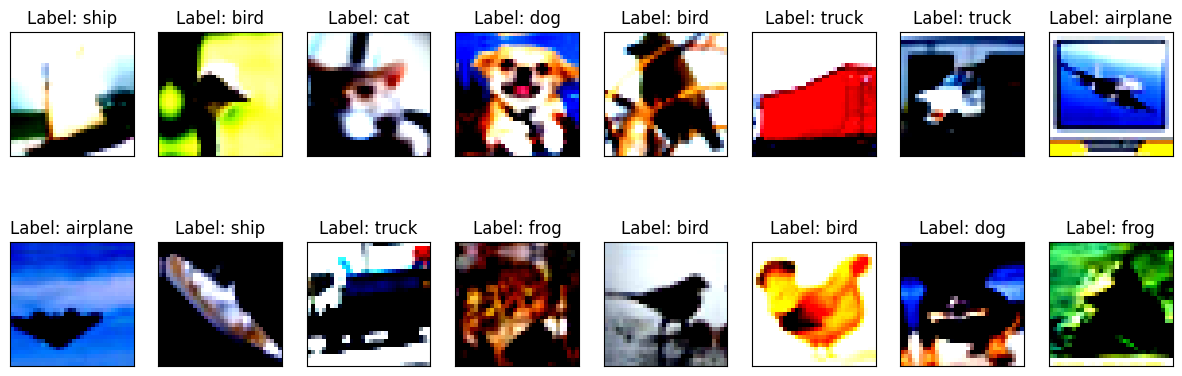

In [7]:
# Calculate Class Scale
from DeepLib.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    # print_class_scale(train_loader, class_map)
    print_samples(train_loader,class_map)# 

Using Device: cuda
Epochs: 20
Lr: 0.01
Max Lr: 0.1
Batch Size: 32
Dropout: False


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             336
       BatchNorm2d-2           [-1, 12, 32, 32]              24
            Conv2d-3           [-1, 12, 32, 32]           1,308
       BatchNorm2d-4           [-1, 12, 32, 32]              24
            Conv2d-5           [-1, 12, 32, 32]             156
         MaxPool2d-6           [-1, 12, 16, 16]               0
           Dropout-7           [-1, 12, 16, 16]               0
            Conv2d-8           [-1, 24, 16, 16]           2,616
       BatchNorm2d-9           [-1, 24, 16, 16]              48
           Conv2d-10           [-1, 24, 16, 16]           5,208
      BatchNorm2d-11           [-1, 24, 16, 16]              48
           Conv2d-12           [-1, 24, 16, 16]           5,208
      BatchNorm2d-13

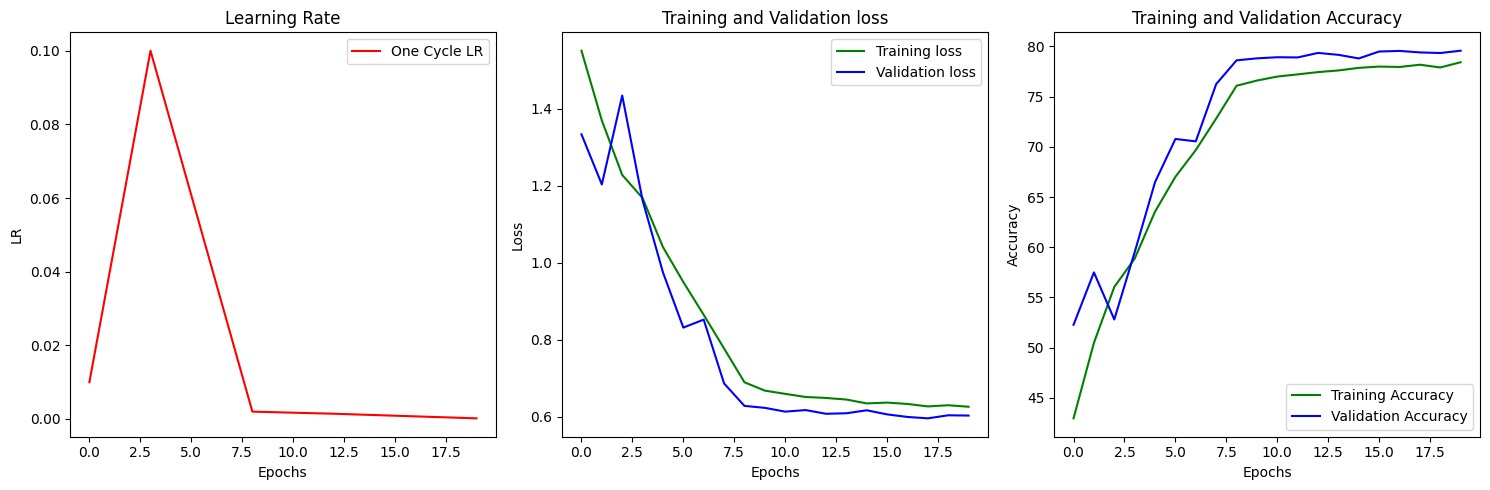

Confusion matrix, without normalization


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Incorrect Predictions 2042


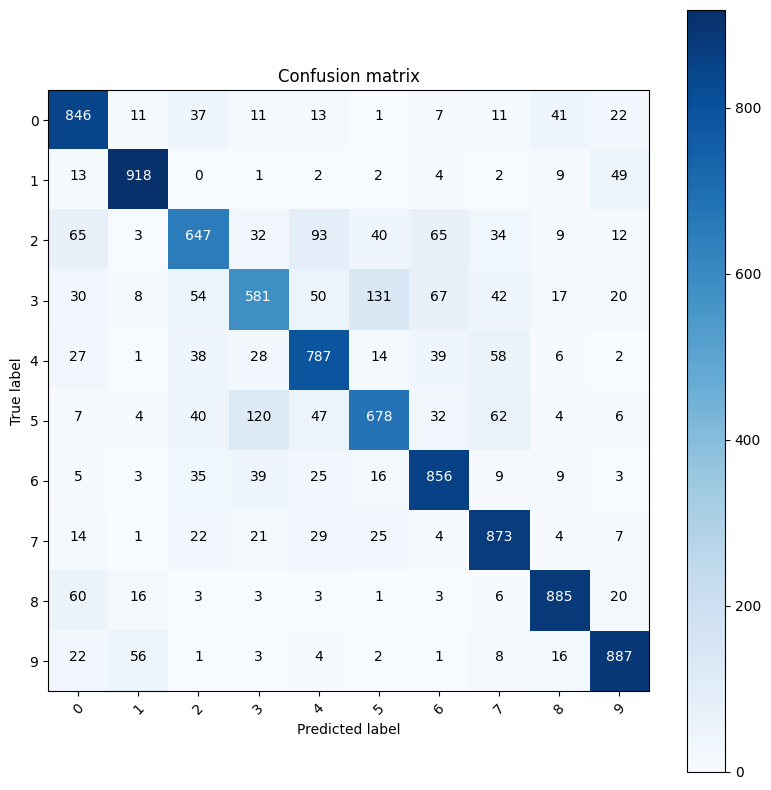

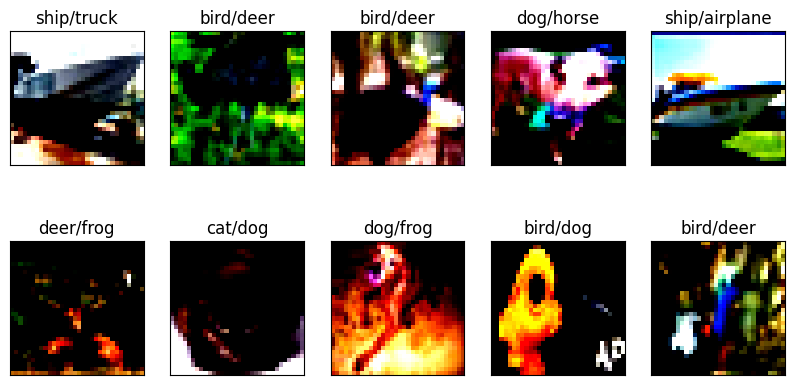

In [8]:
import time
import math

from DeepLib.backpropagation import train, test, get_sgd_optimizer
from DeepLib.utils import initialize_weights
from DeepLib.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from DeepLib.training import Training

# Train Params
epochs = 20
lr = 0.01
max_lr = 0.1
steps_per_epoch = len(train_loader)
dropout = False
momentum = 0.9
weight_decay = 0.000125

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

# bnmodel = CifarNet(norm='bn',base_channels=12).apply(initialize_weights).to(device)
bnmodel = CifarNet(norm='bn',base_channels=12).apply(initialize_weights).to(device)
print_summary(bnmodel, input_size=(3, 32, 32))
optimizer = get_sgd_optimizer(bnmodel, lr=lr, weight_decay=weight_decay)

# Pytorch one cycle scheduler
pytorch_scheduler = one_cycle_lr_pt(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

# One cycle schedule with a custom function
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

trainer = Training(
    bnmodel,
    optimizer,
    custom_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

trainer.run()

from DeepLib.visualize import plot_network_performance

# trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

from DeepLib.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from DeepLib.visualize import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(bnmodel, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)


from DeepLib.utils import get_incorrrect_predictions
from DeepLib.visualize import plot_incorrect_predictions

incorrect = get_incorrrect_predictions(bnmodel, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)

In [9]:
import time
import math

from DeepLib.backpropagation import train, test, get_sgd_optimizer
from DeepLib.utils import initialize_weights
from DeepLib.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from DeepLib.training import Training

# Train Params
epochs = 20
lr = 0.01
max_lr = 0.1
steps_per_epoch = len(train_loader)
dropout = True
momentum = 0.9
weight_decay = 0.000125

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

lnmodel = CifarNet(norm='ln',base_channels=15).apply(initialize_weights).to(device)
print_summary(lnmodel, input_size=(3, 32, 32))
optimizer = get_sgd_optimizer(lnmodel, lr=lr, weight_decay=weight_decay)

# Pytorch one cycle scheduler
pytorch_scheduler = one_cycle_lr_pt(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

# One cycle schedule with a custom function
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

trainer = Training(
    lnmodel,
    optimizer,
    custom_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

trainer.run()

Using Device: cuda
Epochs: 20
Lr: 0.01
Max Lr: 0.1
Batch Size: 32
Dropout: True


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 32, 32]             420
         GroupNorm-2           [-1, 15, 32, 32]              30
            Conv2d-3           [-1, 15, 32, 32]           2,040
         GroupNorm-4           [-1, 15, 32, 32]              30
            Conv2d-5           [-1, 15, 32, 32]             240
         MaxPool2d-6           [-1, 15, 16, 16]               0
           Dropout-7           [-1, 15, 16, 16]               0
            Conv2d-8           [-1, 30, 16, 16]           4,080
         GroupNorm-9           [-1, 30, 16, 16]              60
           Conv2d-10           [-1, 30, 16, 16]           8,130
        GroupNorm-11           [-1, 30, 16, 16]              60
           Conv2d-12           [-1, 30, 16, 16]           8,130
        GroupNorm-13 

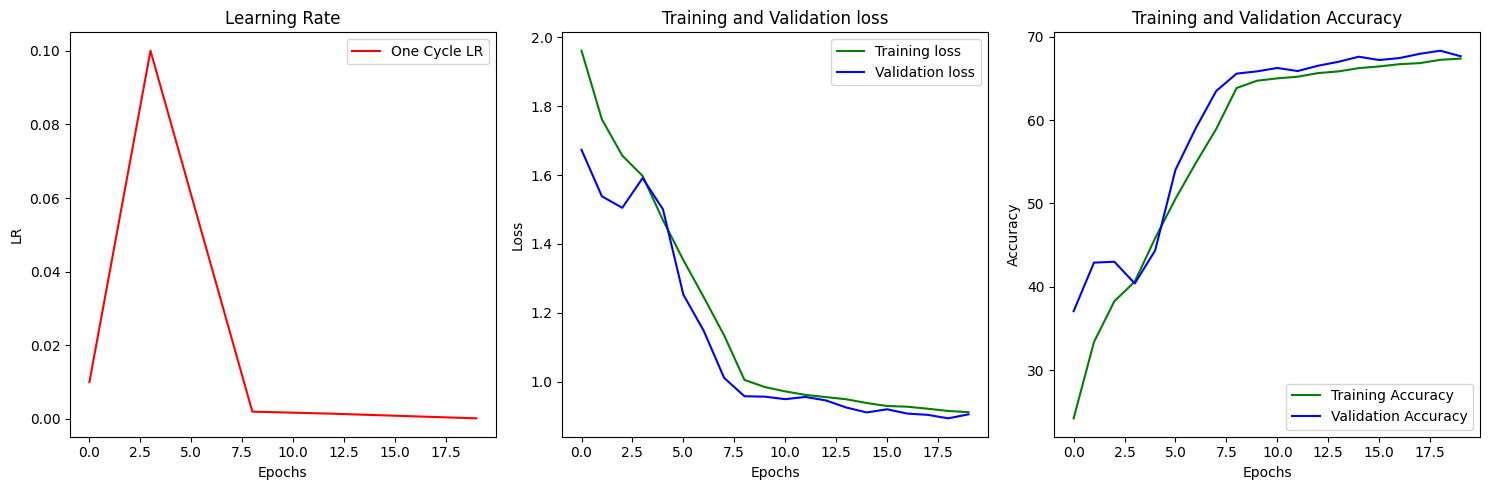

In [10]:
from DeepLib.visualize import plot_network_performance

# trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)


Confusion matrix, without normalization


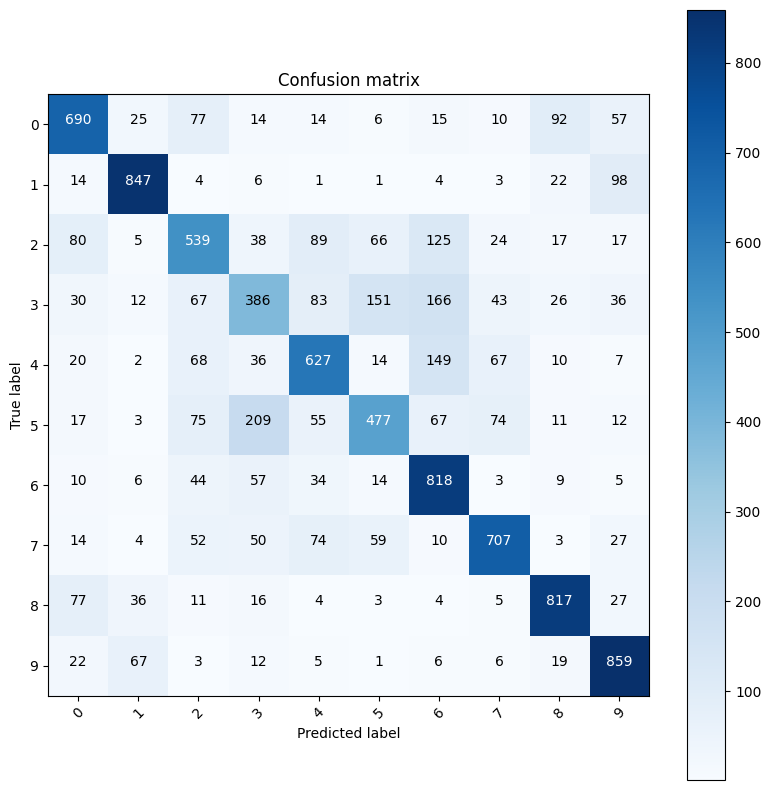

In [11]:
from DeepLib.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from DeepLib.visualize import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(lnmodel, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total Incorrect Predictions 3233


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


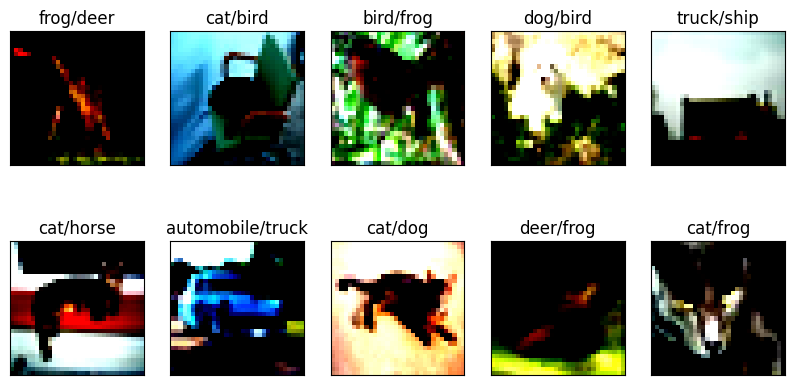

In [12]:
from DeepLib.utils import get_incorrrect_predictions
from DeepLib.visualize import plot_incorrect_predictions

incorrect = get_incorrrect_predictions(lnmodel, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)

Using Device: cuda
Epochs: 20
Lr: 0.01
Max Lr: 0.1
Batch Size: 32
Dropout: True


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 32, 32]             420
         GroupNorm-2           [-1, 15, 32, 32]              30
            Conv2d-3           [-1, 15, 32, 32]           2,040
         GroupNorm-4           [-1, 15, 32, 32]              30
            Conv2d-5           [-1, 15, 32, 32]             240
         MaxPool2d-6           [-1, 15, 16, 16]               0
           Dropout-7           [-1, 15, 16, 16]               0
            Conv2d-8           [-1, 30, 16, 16]           4,080
         GroupNorm-9           [-1, 30, 16, 16]              60
           Conv2d-10           [-1, 30, 16, 16]           8,130
        GroupNorm-11           [-1, 30, 16, 16]              60
           Conv2d-12           [-1, 30, 16, 16]           8,130
        GroupNorm-13 

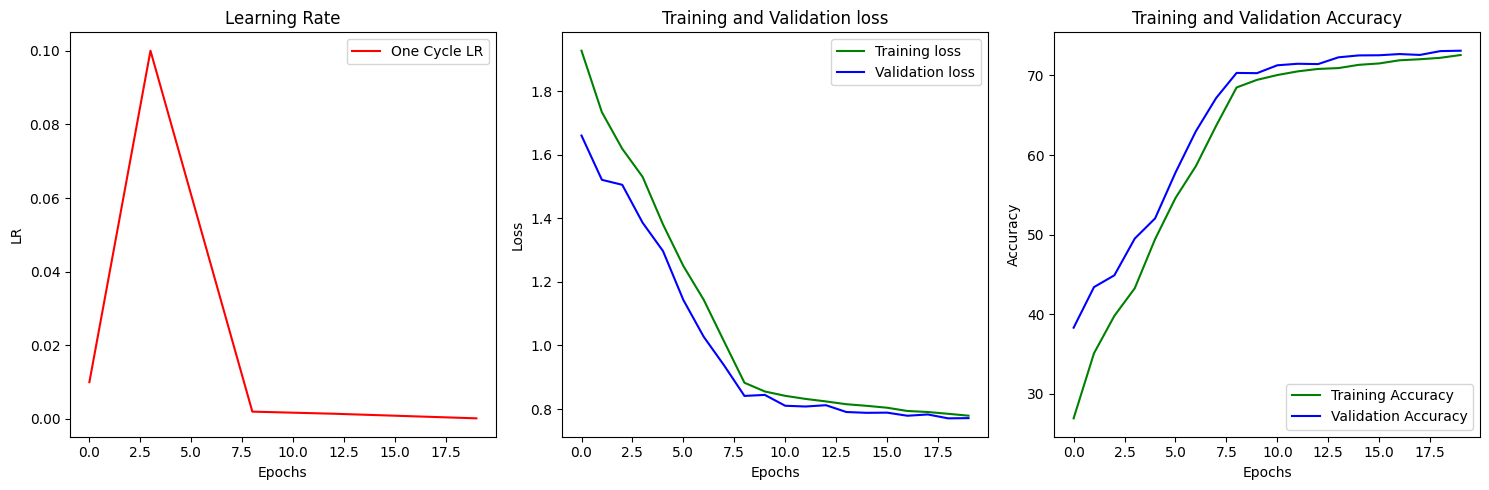

Confusion matrix, without normalization


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Incorrect Predictions 2689


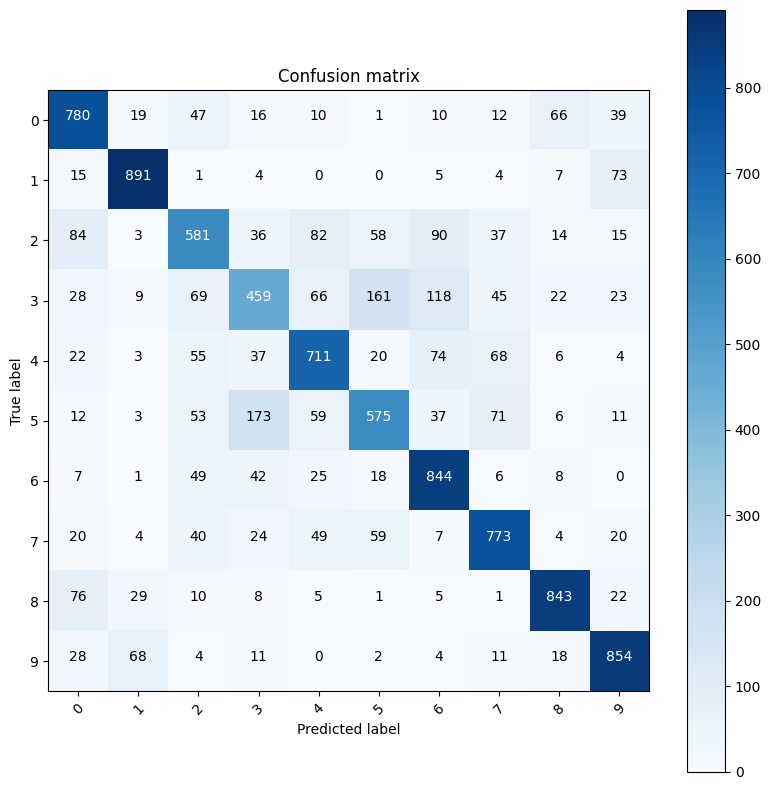

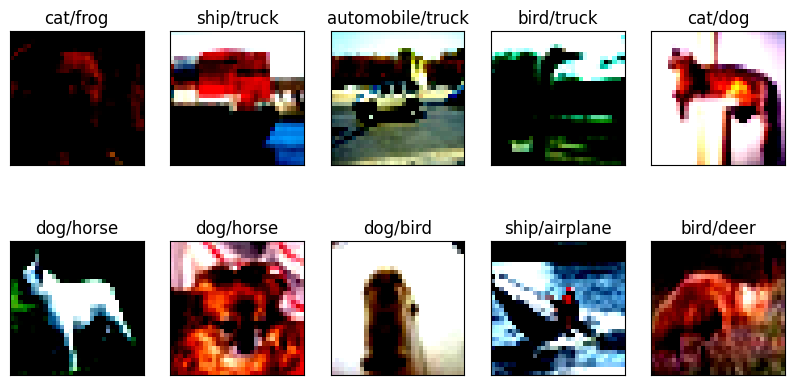

In [13]:
import time
import math

from DeepLib.backpropagation import train, test, get_sgd_optimizer
from DeepLib.utils import initialize_weights
from DeepLib.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from DeepLib.training import Training

# Train Params
epochs = 20
lr = 0.01
max_lr = 0.1
steps_per_epoch = len(train_loader)
dropout = True
momentum = 0.9
weight_decay = 0.000125

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

gnmodel = CifarNet(norm='gn',base_channels=15).apply(initialize_weights).to(device)
optimizer = get_sgd_optimizer(gnmodel, lr=lr, weight_decay=weight_decay)
print_summary(gnmodel, input_size=(3, 32, 32))

# Pytorch one cycle scheduler
pytorch_scheduler = one_cycle_lr_pt(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

# One cycle schedule with a custom function
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

trainer = Training(
    gnmodel,
    optimizer,
    custom_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

trainer.run()

from DeepLib.visualize import plot_network_performance

# trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

from DeepLib.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from DeepLib.visualize import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(gnmodel, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)


from DeepLib.utils import get_incorrrect_predictions
from DeepLib.visualize import plot_incorrect_predictions

incorrect = get_incorrrect_predictions(gnmodel, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)
